In [3]:
import pandas as pd
import numpy as np

print("=== MASTER DATA PIPELINE ===")

GBP_TO_INR = 75

# Load UCI with correct date parsing
uci = pd.read_csv(r"C:\Users\Aniru\OneDrive\Documents\Code\PROJECTS\RetailGPT\data\online_retail_II.csv")

# Rename columns
uci = uci.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
})

# Parse dates - YOUR FORMAT: 12/1/2009 7:45
uci["InvoiceDate"] = pd.to_datetime(uci["InvoiceDate"], format='%m/%d/%Y %H:%M', errors="coerce")

# Clean
uci = uci.dropna(subset=["InvoiceDate", "CustomerID", "Quantity", "UnitPrice"])
uci["Quantity"] = pd.to_numeric(uci["Quantity"], errors="coerce")
uci["UnitPrice"] = pd.to_numeric(uci["UnitPrice"], errors="coerce")
uci = uci.dropna()
uci = uci[(uci["Quantity"] > 0) & (uci["UnitPrice"] > 0)]

# Convert GBP → INR
uci["TotalAmount"] = uci["Quantity"] * uci["UnitPrice"] * GBP_TO_INR
uci["Date"] = uci["InvoiceDate"].dt.date

# Categories (hash-based pseudo categories)
uci["ProductCategory"] = (uci["StockCode"].astype(str).apply(lambda x: hash(x) % 5)).map({
    0: "Electronics", 1: "Clothing", 2: "Beauty", 3: "Home", 4: "Other"
})

uci_master = uci[["Date", "CustomerID", "ProductCategory", "Quantity", "TotalAmount"]].copy()
uci_master = uci_master.rename(columns={"CustomerID": "Customer_ID"})

print(f"✅ UCI: {len(uci_master):,} transactions")
print(f"💰 UCI Revenue (₹75/£): ₹{uci_master['TotalAmount'].sum():,.0f}")
print(f"📅 UCI Date Range: {uci_master['Date'].min()} → {uci_master['Date'].max()}")

# Kaggle
kaggle = pd.read_csv(r"C:\Users\Aniru\OneDrive\Documents\Code\PROJECTS\RetailGPT\data\retail_sales_dataset.csv")
kaggle["Date"] = pd.to_datetime(kaggle["Date"], dayfirst=True).dt.date
kaggle = kaggle.rename(columns={"Customer ID":"Customer_ID", "Product Category":"ProductCategory", "Total Amount":"TotalAmount"})
kaggle = kaggle[["Date","Customer_ID","ProductCategory","Quantity","TotalAmount"]].dropna()

print(f"\n✅ Kaggle: {len(kaggle):,} transactions")
print(f"💰 Kaggle Revenue: ₹{kaggle['TotalAmount'].sum():,.0f}")

# Master
master = pd.concat([uci_master, kaggle], ignore_index=True)
master = master.dropna()

print(f"\n🎉 MASTER DATASET: {len(master):,} TOTAL TRANSACTIONS")
print(f"💰 Total Revenue: ₹{master['TotalAmount'].sum():,.0f}")
print(f"📅 Full Range: {master['Date'].min()} → {master['Date'].max()}")
print("\n📊 Top Categories:")
print(master["ProductCategory"].value_counts().head())

master.to_csv(r"C:\Users\Aniru\OneDrive\Documents\Code\PROJECTS\RetailGPT\data/master_retail_inr.csv", index=False)
print("\n💾 Saved: data/master_retail_inr.csv")

=== MASTER DATA PIPELINE ===
✅ UCI: 407,664 transactions
💰 UCI Revenue (₹75/£): ₹662,400,246
📅 UCI Date Range: 2009-12-01 → 2010-12-09

✅ Kaggle: 1,000 transactions
💰 Kaggle Revenue: ₹456,000

🎉 MASTER DATASET: 408,664 TOTAL TRANSACTIONS
💰 Total Revenue: ₹662,856,246
📅 Full Range: 2009-12-01 → 2024-01-01

📊 Top Categories:
ProductCategory
Clothing       90665
Electronics    83379
Other          82132
Beauty         76691
Home           75797
Name: count, dtype: int64

💾 Saved: data/master_retail_inr.csv


In [4]:
# Google Trends Integration
from pytrends.request import TrendReq
import pickle

try:
    pytrends = TrendReq(hl='en-US', tz=360)
    keywords = ['smartphone', 'clothing', 'cosmetics', 'electronics']
    pytrends.build_payload(keywords, timeframe='2009-12-01 2024-01-31', geo='IN')
    trends = pytrends.interest_over_time()
    
    trends.to_pickle('../data/trends_cache.pkl')
    print("✅ Google Trends cached:", trends.shape)
    trends.tail()
except Exception as e:
    print(f"⚠️ Trends API blocked (normal): {e}")
    print("Creating dummy trends data...")
    # Dummy data
    import pandas as pd
    trends = pd.DataFrame({
        'smartphone': [50]*100,
        'clothing': [60]*100,
        'cosmetics': [40]*100,
        'electronics': [70]*100
    })
    trends.to_pickle('../data/trends_cache.pkl')
    print("✅ Dummy trends cached")


✅ Google Trends cached: (170, 5)


📊 BATCH 1 VALIDATION - MASTER DATASET
✅ Transactions: 408,664
✅ Date range: 2009-12-01 → 2024-01-01
✅ Total revenue: ₹662,856,246
✅ Unique customers: 5,836
✅ Categories: 5

📈 Daily Sales Trend:


C:\Users\Aniru\AppData\Local\Temp\ipykernel_26848\3289895862.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv('../data/master_retail_inr.csv')


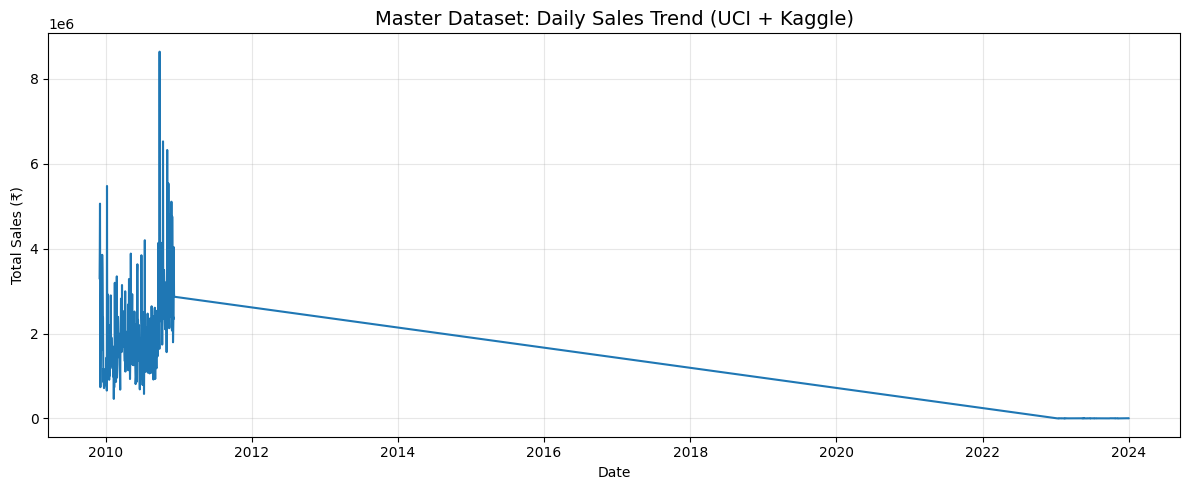

: 

In [ ]:
# Master Data Validation
import matplotlib.pyplot as plt

master = pd.read_csv('../data/master_retail_inr.csv')
master['Date'] = pd.to_datetime(master['Date'])

print("="*50)
print("📊 BATCH 1 VALIDATION - MASTER DATASET")
print("="*50)
print(f"✅ Transactions: {len(master):,}")
print(f"✅ Date range: {master['Date'].min().date()} → {master['Date'].max().date()}")
print(f"✅ Total revenue: ₹{master['TotalAmount'].sum():,.0f}")
print(f"✅ Unique customers: {master['Customer_ID'].nunique():,}")
print(f"✅ Categories: {master['ProductCategory'].nunique()}")
print("\n📈 Daily Sales Trend:")

# Validation plot
daily_sales = master.groupby('Date')['TotalAmount'].sum()
plt.figure(figsize=(12,5))
plt.plot(daily_sales.index, daily_sales.values, linewidth=1.5)
plt.title("Master Dataset: Daily Sales Trend (UCI + Kaggle)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total Sales (₹)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
